# Particle Filters Usecass
______

Train MSE: 31.9345
Test MSE: 34.4528


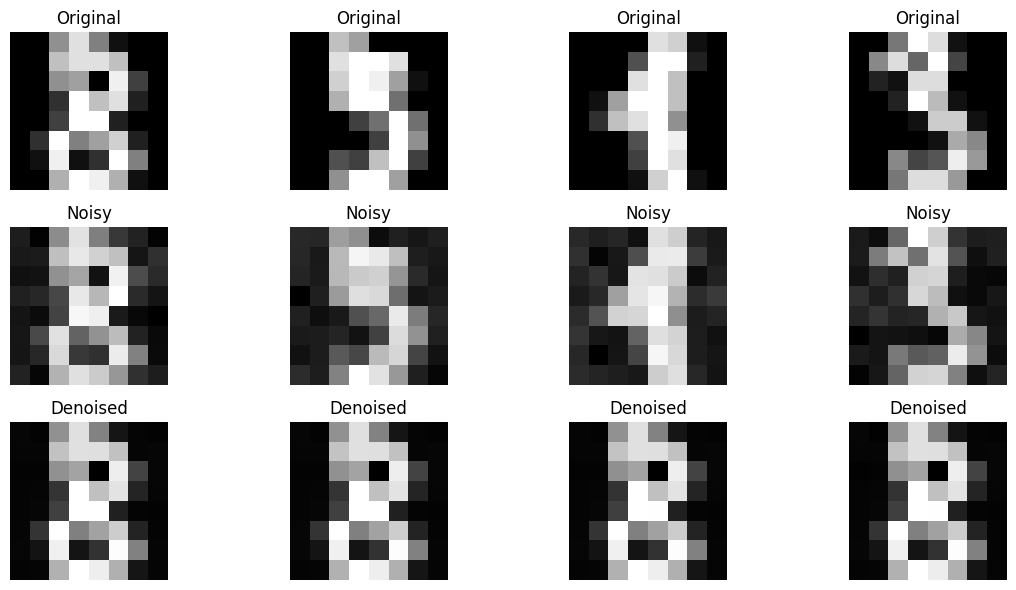

Classification Accuracy: 0.0000


In [1]:
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from  tfilterspy.state_estimation.linear_filters import DaskKalmanFilter
from  tfilterspy.state_estimation.particle_filters import DaskParticleFilter

# Load and split the digits dataset (20 samples)
digits = load_digits()
x = digits.data[0:20]  # Shape: (20, 64)
y = digits.target[0:20]  # Shape: (20,)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays
x_train_dask = da.from_array(x_train, chunks=(10, 64))  # 16 samples
x_test_dask = da.from_array(x_test, chunks=(10, 64))    # 4 samples
y_train_dask = da.from_array(y_train, chunks=(10,))
y_test_dask = da.from_array(y_test, chunks=(10,))

# Add synthetic noise
noise_level = 0.88
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)
noisy_x_test_dask = x_test_dask + da.random.normal(0, noise_level, x_test_dask.shape, chunks=x_test_dask.chunks)

# Particle Filter Setup
n_features = 64  # 8x8 pixels
F = np.eye(n_features)  # Static transition
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
initial_state = x_train[0]     # First clean image as initial guess

pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=initial_state,
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)

# Denoise Training and Test Sets
train_states, _ = pf.run_filter(noisy_x_train_dask)
denoised_x_train = train_states.compute()  # Shape: (16, 64)

# Reinitialize for test set (optional: could reuse same filter state)
pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=x_test[0],  # First test image
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)
test_states, _ = pf.run_filter(noisy_x_test_dask)
denoised_x_test = test_states.compute()  # Shape: (4, 64)

# Evaluate Denoising
mse_train = np.mean((x_train - denoised_x_train) ** 2)
mse_test = np.mean((x_test - denoised_x_test) ** 2)
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

# Visualize (first 4 training images)
n_display = 4
plt.figure(figsize=(12, 6))
for i in range(n_display):
    # Original
    plt.subplot(3, n_display, i + 1)
    plt.imshow(x_train[i].reshape(8, 8), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    # Noisy
    plt.subplot(3, n_display, i + 1 + n_display)
    plt.imshow(noisy_x_train_dask[i].compute().reshape(8, 8), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    # Denoised
    plt.subplot(3, n_display, i + 1 + 2 * n_display)
    plt.imshow(denoised_x_train[i].reshape(8, 8), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Optional: Classification
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(denoised_x_train, y_train)
y_pred = clf.predict(denoised_x_test)
accuracy = np.mean(y_pred == y_test)
print(f"Classification Accuracy: {accuracy:.4f}")

# Multi-variate Time Series

In [2]:
from sklearn.datasets import fetch_openml
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
# from your_module import DaskParticleFilter  # Adjust import

# 1. Load EEG Eye State data
data = fetch_openml(name='eeg-eye-state', version=1, as_frame=False)
X = data.data[0:20]  # Shape: (14980, 14)
X_dask = da.from_array(X, chunks=(1000, 14))
print(f"Data shape: {X_dask.shape}")

# 2. Add Synthetic Noise
noise_level = 0.5  # Adjust noise intensity
noisy_X_dask = X_dask + da.random.normal(0, noise_level, X_dask.shape, chunks=X_dask.chunks)

# 3. Particle Filter Setup
n_features = 14  # 14 EEG channels
F = np.eye(n_features) * 0.99  # Slow drift (near-static transition)
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
initial_state = X[0]           # First timestep as initial state

pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=initial_state,
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)

# 4. Run Filter to Denoise
state_estimates, residuals = pf.run_filter(noisy_X_dask)
denoised_X = state_estimates.compute()  # Shape: (14980, 14)

# 5. Evaluate
mse = np.mean((X - denoised_X) ** 2)
print(f"Mean Squared Error: {mse:.4f}")

# 6. Visualize (first 1000 timesteps, all channels)
subset_size = 1000
X_subset = X[:subset_size]
noisy_subset = noisy_X_dask[:subset_size].compute()
denoised_subset = denoised_X[:subset_size]

plt.figure(figsize=(15, 10))
for i in range(14):
    plt.subplot(7, 2, i + 1)
    plt.plot(X_subset[:, i], label="Original", alpha=0.5)
    plt.plot(noisy_subset[:, i], label="Noisy", alpha=0.5)
    plt.plot(denoised_subset[:, i], label="Denoised", linestyle="--")
    plt.title(f"EEG Channel {i+1}")
    plt.xlabel("Time (timesteps)")
    plt.ylabel("Amplitude")
    plt.legend()
plt.tight_layout()
plt.show()

ImportError: Using `parser='auto'` with dense data requires pandas to be installed. Alternatively, explicitly set `parser='liac-arff'`.

In [3]:
pip install pandas



   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.6 MB 3.4 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/11.6 MB 2.6 MB/s eta 0:00:04
   ----- ---------------------------------- 1.6/11.6 MB 2.5 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.6 MB 2.5 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/11.6 MB 2.4 MB/s eta 0:00:04
   ---------- ----------------------------- 3.1/11.6 MB 2.4 MB/s eta 0:00:04
   ------------ --------------------------- 3.7/11.6 MB 2.4 MB/s eta 0:00:04
   -------------- ------------------------- 4.2/11.6 MB 2.4 MB/s eta 0:00:04
   ---------------- ----------------------- 4.7/11.6 MB 2.4 MB/s eta 0:00:03
   ------------------ --------------------- 5.2/11.6 MB 2.4 MB/s eta 0:00:03
   ------------------- -------------------- 5.8/11.6 MB 2.4 MB/s eta 0:00:03
   --------------------- ------------------ 6.3/11.6 MB 2.4 MB/s eta 0:00:03
   --

In [4]:
import pandas as pd
import numpy as np
import dask.array as da
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
# from your_module import DaskParticleFilter  # Adjust import

# 1. Load Disaster Tweets
data_path = r'C:\Users\thabanglukhetho\Documents\gits\tfilterPy\examples\data\train_nlp.csv'
df = pd.read_csv(data_path)
tweets = df['text'].values[0:5000]  # 500 tweets for testing
print(f"Number of tweets: {len(tweets)}")

# 2. Preprocess and Extract Topics
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(tweets)
n_topics = 5  # e.g., disaster, weather, casual, news, other
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topic_dist = lda.fit_transform(X)  # Shape: (500, 5)
X_dask = da.from_array(topic_dist, chunks=(100, n_topics))  # Adjusted chunks for 500 samples
print(f"Topic distribution shape: {X_dask.shape}")

# 3. Particle Filter Setup
F = np.eye(n_topics) * 0.95  # Slight decay for smooth topic evolution
H = np.eye(n_topics)  # Direct observation
Q = np.eye(n_topics) * 0.01  # Process noise
R = np.eye(n_topics) * 0.1   # Observation noise
initial_state = topic_dist[0]  # First tweet’s topics

pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=initial_state,
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)

# 4. Run Filter to Track Topics
state_estimates, residuals = pf.run_filter(X_dask)
smoothed_topics = state_estimates.compute()  # Shape: (500, 5)

# 5. Plot Raw vs Smoothed Topics (first 500 tweets)
subset_size = 500  # Full set since we’re using 500 tweets
plt.figure(figsize=(12, 8))
for i in range(n_topics):
    plt.subplot(n_topics, 1, i + 1)
    plt.plot(topic_dist[:subset_size, i], label=f"Raw Topic {i+1}", alpha=0.5)
    plt.plot(smoothed_topics[:subset_size, i], label=f"Filtered Topic {i+1}", linestyle="--")
    plt.title(f"Topic {i+1}")
    plt.xlabel("Tweet Index (Time)")
    plt.ylabel("Probability")
    plt.legend()
plt.tight_layout()
plt.show()

# 6. Interpret Topics
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words = [feature_names[j] for j in topic.argsort()[-5:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")

# 7. Optional: Check Final State and Parameters
print("Final estimated state:", pf.state)
Q_est, R_est = pf.estimate_parameters(X_dask)
print("Estimated Q:", Q_est.compute())
print("Estimated R:", R_est.compute())

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\thabanglukhetho\\Documents\\gits\\tfilterPy\\examples\\data\\train_nlp.csv'